In [178]:
from wipy.wipy_utils import utils
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import obspy

n_events = 41
n_iters = 0

In [179]:
# gather_names = "Up_file_single_p.su_proc"
gather_names =  "Uz_file_single_d.su_proc"
shot_num = 0
path00 = "scratch/traces/syn/{:06d}/".format(shot_num) + gather_names
path01 = "scratch/traces/obs/{:06d}/".format(shot_num) + gather_names
path02 = "scratch/traces/adj/{:06d}/Uz_file_single.su.adj".format(shot_num)

syn = obspy.read(path00, format="SU")
obs = obspy.read(path01, format="SU")
adj = obspy.read(path02, format="SU")

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
    ["blue", "cyan", "gray", "yellow", "red"])

# fig, ax = utils.plot_image(syn, 1, cmap)
# ax.invert_yaxis()

# fig, ax = utils.plot_image(obs, 1, cmap)
# ax.invert_yaxis()

# fig, ax = utils.plot_image(adj, 1, cmap)
# ax.invert_yaxis()

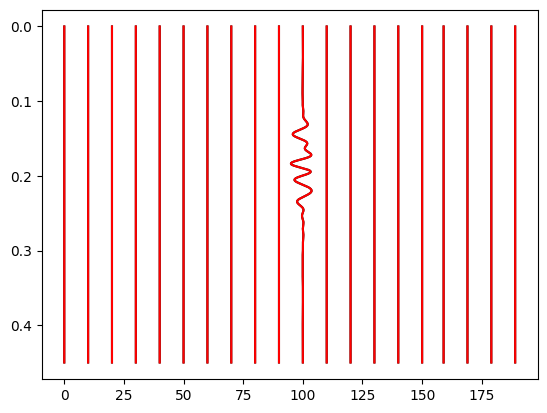

In [180]:
utils.plot_traces(obs, gain=5, deci=20)
utils.plot_traces(syn, gain=5, line_spec="r-", deci=20)
plt.gca().invert_yaxis()
plt.show()



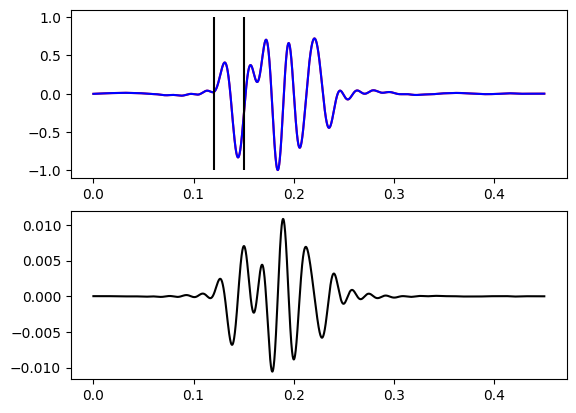

In [184]:
t = np.arange(0, syn[0].stats.npts) * syn[0].stats.delta

plt.subplot(211)
plt.plot(t, syn[201].data, color="red")
plt.plot(t, obs[201].data, color="blue")
plt.vlines(0.12, -1, 1, color="black")
plt.vlines(0.15, -1, 1, color="black")
plt.subplot(212)
plt.plot(t, adj[201].data, color="black")



In [176]:
model_init_path = "model_init"

pars = ["x", "z", "rho", "vp", "vs"]

model_init = utils.load_model(model_init_path, pars)

# fig, ax = utils.plot_model(model_init, 25, "vs", bounds=[250.0, 3000.0],)
# fig, ax = utils.plot_model(model_init, 25, "vp", bounds=[450.0, 5000.0],)


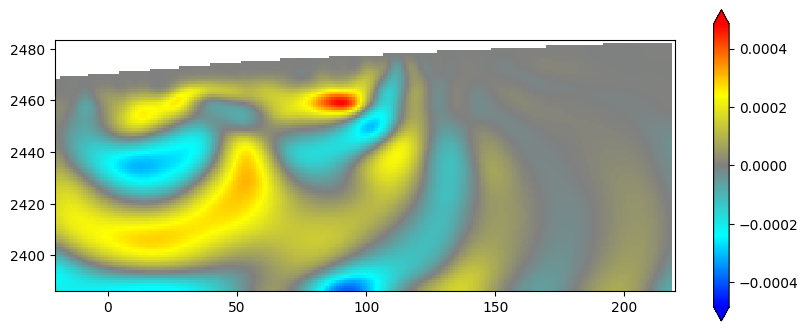

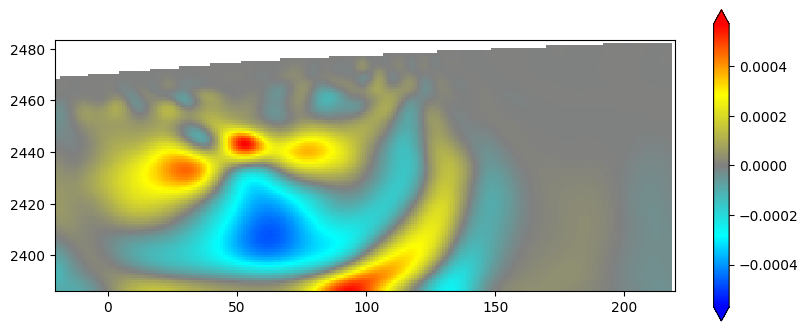

In [177]:
# plot gradient / sensitivity kernel

# kernel_path = "OUTPUT/grad_0000/"
kernel_path = "OUTPUT/grad_precond/"
pars = ["grad_vp", "grad_vs"]
# kernel_path = "scratch/eval_grad/sum/"
# pars = ["c_acoustic_kernel", "Hessian1_acoustic_kernel"]
# pars = ["Hessian1_acoustic_kernel"]
# kernel_path = "scratch/eval_grad/sum_smooth/"
# pars = ["c_acoustic_kernel_smooth"]
# pars = ["Hessian1_acoustic_kernel_smooth"]
kernel = utils.load_model(kernel_path, pars)
kernel = kernel | model_init

fig, ax = utils.plot_model_fast(
    kernel,
    1,
    pars[0],
    bounds=[1*-np.max(np.abs(kernel[pars[0]])), 1*np.max(np.abs(kernel[pars[0]]))],
    cmap = cmap    
)
plt.show()

fig, ax = utils.plot_model_fast(
    kernel,
    1,
    pars[1],
    bounds=[-np.max(np.abs(kernel[pars[1]])), np.max(np.abs(kernel[pars[1]]))],
    cmap = cmap
)
# # plt.show()

# kernel_path = "scratch/eval_grad/sum_smooth/"
# pars = ["Hessian1_kernel_smooth"]
# kernel = utils.load_model(kernel_path, pars)
# kernel = kernel | model_init
# kernel["hess"] = 1/kernel[pars[0]]
# fig, ax = utils.plot_model(kernel, 25, "hess")
# plt.show()


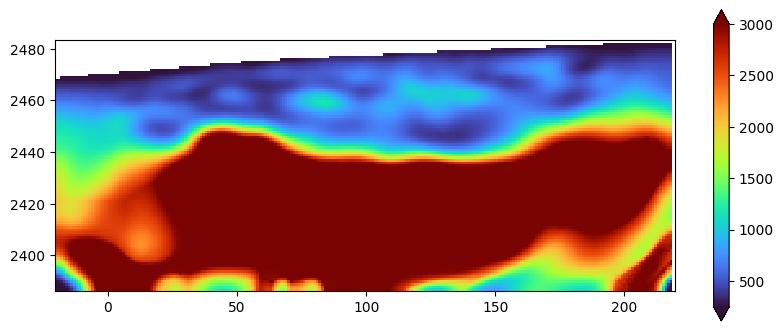

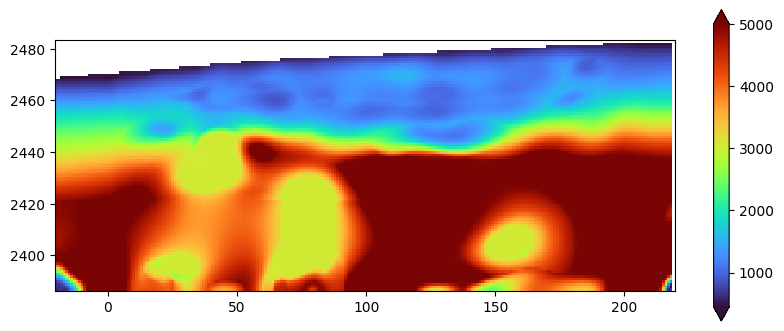

In [71]:
model_final_path = "OUTPUT/model_" + "{:04d}".format(n_iters)

model_final = utils.load_model(model_path=model_final_path, pars=["vp", "vs"])

model_final = model_init | model_final
# model_final["vp:vs"] = model_final["vp"]/model_final["vs"]
model_final["delta_vp"] = model_final["vp"] - model_init["vp"]

fig, ax = utils.plot_model_fast(model_final, 1, "vs", bounds=[250, 3000])
# plt.hlines(2460, 0, 200, color="black")
fig, ax = utils.plot_model_fast(model_final, 1, "vp", bounds=[450, 5000])
# plt.hlines(2460, 0, 200, color="black")

# fig, ax = utils.plot_model(model_final, 25, "vs", bounds=[250, 3000])
# fig, ax = utils.plot_model(model_final, 25, "vp", bounds=[450, 5000])
# fig, ax = utils.plot_model(model_final, 25, "delta_vp", bounds=[-1000, 1000])
# fig, ax = utils.plot_model(model_final, 25, "vp:vs")


In [72]:
def sum_residuals(base_path, n_events) -> float: 
    """
    reads the residuals in and summs the residuals from multiple events together
    """
    resid_paths = ["/".join([base_path, "residuals", "{:06d}".format(num)]) for num in range(n_events)]
    ml = []
    misfit = 0
    for path in resid_paths:
        m = np.sum(np.loadtxt(path))
        ml.append(m)
        misfit += m

    misfit /= n_events

    return misfit, ml


In [73]:
misfit = []
ML = []
for i in range(0, n_iters+1):
    resid_path = "OUTPUT/residuals_{:04d}/".format(i)
    m, ml = sum_residuals(resid_path, n_events)
    misfit.append(m)
    ML.append(ml)

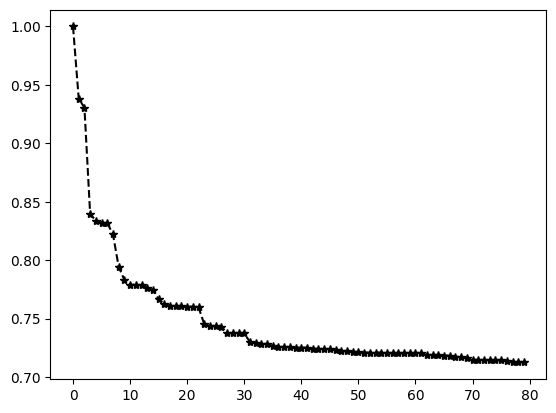

In [75]:
plt.plot(misfit/misfit[0], "k*--")

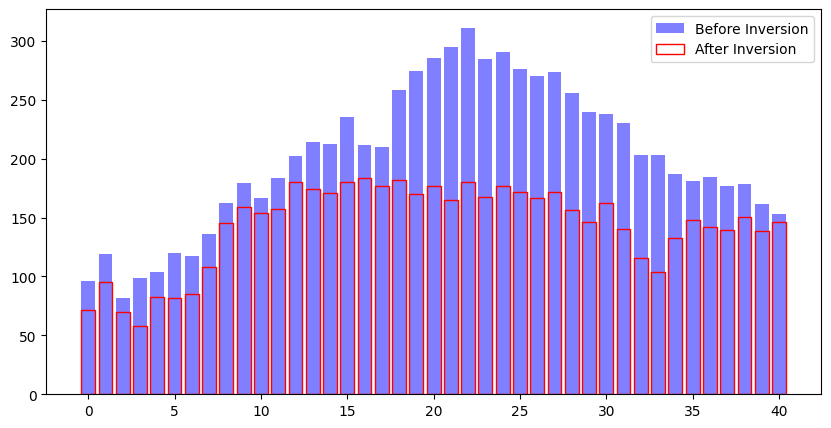

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(np.arange(0,n_events), ML[0], width=0.8, alpha=0.5, color="b", edgecolor=None, label="Before Inversion")
ax.bar(np.arange(0,n_events), ML[-1], width=0.8, alpha=1, color="None", edgecolor="r", label="After Inversion")
ax.legend()
